In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [34]:



start = dt.datetime(2015, 1, 1)
end = dt.datetime(2023,1,1)


tesla_data = yf.download('TSLA', start=start, end=end)

print(tesla_data.head())
tesla_data.shape
tesla_data.info()


[*********************100%***********************]  1 of 1 completed

Price       Adj Close      Close       High        Low       Open    Volume
Ticker           TSLA       TSLA       TSLA       TSLA       TSLA      TSLA
Date                                                                       
2015-01-02  14.620667  14.620667  14.883333  14.217333  14.858000  71466000
2015-01-05  14.006000  14.006000  14.433333  13.810667  14.303333  80527500
2015-01-06  14.085333  14.085333  14.280000  13.614000  14.004000  93928500
2015-01-07  14.063333  14.063333  14.318667  13.985333  14.223333  44526000
2015-01-08  14.041333  14.041333  14.253333  14.000667  14.187333  51637500
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2014 entries, 2015-01-02 to 2022-12-30
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, TSLA)  2014 non-null   float64
 1   (Close, TSLA)      2014 non-null   float64
 2   (High, TSLA)       2014 non-null   float64
 3   (Low, TSLA)        2014

In [35]:
# Prepare Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tesla_data[("Close", "TSLA")].values.reshape(-1, 1))
scaled_data

array([[0.01259433],
       [0.01105916],
       [0.0112573 ],
       ...,
       [0.25757757],
       [0.28033027],
       [0.28372695]])

In [36]:
prediction_days=100

In [37]:
x_train=[]
y_train=[]

In [38]:
for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0]) 

In [39]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

training the model

In [40]:
model=Sequential()

In [41]:
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1)) # Prediction of the next closing value

c:\Users\micha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:



test_start = dt.datetime(2023, 2, 2)
test_end = dt.datetime.now()


test_tesla_data = yf.download('TSLA', start=test_start, end=test_end)
actual_prices=test_tesla_data[("Close", "TSLA")].values
# print(test_tesla_data)

[*********************100%***********************]  1 of 1 completed

Price        Adj Close       Close        High         Low        Open  \
Ticker            TSLA        TSLA        TSLA        TSLA        TSLA   
Date                                                                     
2023-02-02  188.270004  188.270004  196.750000  182.610001  187.330002   
2023-02-03  189.979996  189.979996  199.000000  183.690002  183.949997   
2023-02-06  194.759995  194.759995  198.169998  189.919998  193.009995   
2023-02-07  196.809998  196.809998  197.500000  189.550003  196.429993   
2023-02-08  201.289993  201.289993  203.000000  194.309998  196.100006   
...                ...         ...         ...         ...         ...   
2024-11-22  352.559998  352.559998  361.529999  337.700012  341.089996   
2024-11-25  338.589996  338.589996  361.929993  338.200012  360.140015   
2024-11-26  338.230011  338.230011  346.959991  335.660004  341.000000   
2024-11-27  332.890015  332.890015  342.549988  326.589996  341.799988   
2024-11-29  345.160004  345.160004  34

In [49]:
total_dataset = pd.concat((tesla_data[("Close", "TSLA")],test_tesla_data[("Close", "TSLA")]), axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_tesla_data) - prediction_days: ].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [50]:
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

predicted_price = model.predict(x_test)
predicted_price = scaler.inverse_transform(predicted_price)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step


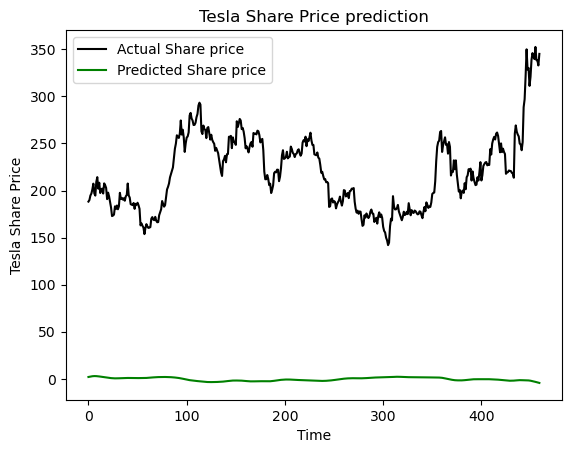

In [53]:
plt.plot(actual_prices, color='black',label='Actual Share price')
plt.plot(predicted_price, color='green',label='Predicted Share price')
plt.title(f"Tesla Share Price prediction")
plt.xlabel('Time')
plt.ylabel(f'Tesla Share Price')
plt.legend()
plt.show()


In [57]:
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days : len(model_inputs)+1, 0]]
real_data =  np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Tomorrow's Tesla share price: {prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Tomorrow's Tesla share price: [[-4.588677]]
